# Import Libraries

In [1]:
import sys
import warnings
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from skopt.space import Real, Categorical, Integer
sys.path.append("../src")
warnings.simplefilter('ignore')
from preprocessing.load_data import load_processed
from models.tune_models import GridSearchTuner, RandomSearchTuner, BayesianSearchTuner

# Functions

In [2]:
def check_param_estimate_with_model(estimator, parameter: str, parameter_values: List, metric="mae", test_on_new_data=True, verbose=True):
    parameter_grid = {parameter: parameter_values}
    model = GridSearchTuner(data= df, estimator=estimator, params=parameter_grid, cv=5, metric=metric)
    
    if verbose:
        print("searching for the best parameters...")
        best_score, best_params = model.search_best()
        print("found best parameters...")
        print(f"Best score: {best_score}")
        print(f"Best params: {best_params}")
        
    if test_on_new_data:
        # check if model still overfits
        print("Estimate of the data on a new sample data: ")
        model.validate()
        model.evaluate_model("mae")
    return model

In [3]:
def plot_params(model, parameter_values: List, plot_title: str, x_label: str, y_label: str, verbose: bool = False):
    means = model.model.cv_results_['mean_test_score']
    stds = model.model.cv_results_['std_test_score']
    params = model.model.cv_results_['params']
    
    if verbose:
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))
  
    plt.errorbar(parameter_values, means, yerr=stds)
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

# Data Loading

In [4]:
df = load_processed("../data/bmw.csv")

# HyperParameter Tuning

## Random Forest 

### Tuning with Random Sampling

In [5]:
# define parameter search space
n_estimators = [100, 200, 500, 750]
max_depth = [5, 10, 20, 50, None]

rf_params = {'n_estimators': n_estimators,
               'max_depth': max_depth}

In [6]:
# search for best parameters
random_rf = RandomSearchTuner(data= df, estimator=RandomForestRegressor, params = rf_params, cv=4, n_iter=50, metric="mae", n_jobs=1)
best_score, best_params = random_rf.search_best()
print(f"Best score: {best_score}")
print(f"Best params: {best_params}")

Best score: -2003.4551335895867
Best params: {'n_estimators': 200, 'max_depth': 20}


In [7]:
# check if model still overfits
random_rf.validate()
random_rf.evaluate_model("mae")

The Train mae: 784.8855860100639
The Test mae: 1994.0362731777757


### Tuning with Grid Search

In [8]:
# create the grid for the parameters
grid_params = {'n_estimators': [200, 250, 300, 350], 'max_depth': [20, 35, 45]}

In [9]:
grid_rf = GridSearchTuner(data= df, estimator=RandomForestRegressor, params = grid_params, cv=4, metric="mae")
best_score, best_params = grid_rf.search_best()
print(f"Best score: {best_score}")
print(f"Best params: {best_params}")

Best score: -2004.525473142557
Best params: {'max_depth': 20, 'n_estimators': 250}


In [10]:
# check if model still overfits
grid_rf.validate()
grid_rf.evaluate_model("mae")

The Train mae: 781.9009185293344
The Test mae: 1984.2777404408762


### Tuning with Bayesian Search

In [11]:
# define the search space for the parameters
search_params = {
     'n_estimators': Integer(200,400),
     'max_depth': Integer(20, 200),
    'min_samples_leaf': Integer(1, 20),
    'min_samples_split': Integer(2, 20)
      }

In [12]:
bayes_rf = BayesianSearchTuner(data= df, estimator=RandomForestRegressor, params = search_params, cv=5, n_iter=100, metric="mae")
best_score, best_params = bayes_rf.search_best()
print(f"Best score: {best_score}")
print(f"Best params: {best_params}")

Best score: -1982.531406440241
Best params: OrderedDict([('max_depth', 20), ('min_samples_leaf', 1), ('min_samples_split', 5), ('n_estimators', 400)])


In [13]:
bayes_rf.validate()
bayes_rf.evaluate_model("mae")

The Train mae: 1036.7342301101246
The Test mae: 1975.7707397146223


## XgBoost

### Tuning with Random Sampling

In [14]:
# define the parameter search space for XgBoost
n_estimators = [100, 200, 500]
max_depth = [1, 3, 5, 7, 9]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
subsample = [0.1, 0.5, 0.7, 1.0]
colsample_bytree = [0.1, 0.4, 0.5, 0.8, 1.0]
reg_alpha = [0.001, 0.01, 0.1, 1.0, 2.0]
reg_lambda = [0.001, 0.01, 0.1, 1.0, 2.0]

            
xgb_params = {'n_estimators': n_estimators,
             'max_depth': max_depth,
             'learning_rate': learning_rate,
             'subsample': subsample,
             'colsample_bytree': colsample_bytree,
             'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda
             }

In [15]:
# find the best hyperparameters
random_xgb = RandomSearchTuner(data= df, estimator=XGBRegressor, params = xgb_params, cv=4, n_iter=50, metric="mae")
best_score, best_params = random_xgb.search_best()
print(f"Best score: {best_score}")
print(f"Best params: {best_params}")

Best score: -1983.4095718842739
Best params: {'subsample': 1.0, 'reg_lambda': 0.001, 'reg_alpha': 0.001, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.4}


In [16]:
# check if the model overfits
random_xgb.validate()
random_xgb.evaluate_model("mae")

The Train mae: 984.9749992673164
The Test mae: 1948.0504411244392


### Tuning with Grid Search

#### Tune number of trees

In [38]:
parameter_values=[100, 150, 300, 350, 500, 1000]
grid_xgb = check_param_estimate_with_model(estimator=XGBRegressor, parameter='n_estimators', parameter_values=parameter_values)

searching for the best parameters...
found best parameters...
Best score: -1974.408368193166
Best params: {'n_estimators': 100}
Estimate of the data on a new sample data: 
The Train mae: 1301.3295352359294
The Test mae: 1992.4261409759522


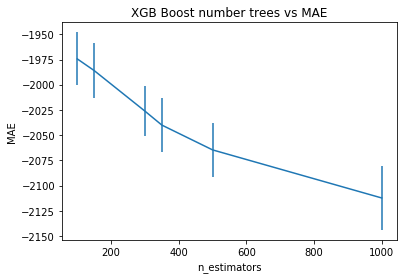

In [39]:
plot_params(model=grid_xgb, parameter_values=parameter_values, plot_title="XGB Boost number trees vs MAE", x_label="n_estimators", y_label="MAE", verbose=False)

#### Tune max_dept

In [40]:
parameter_values=[1, 3, 5, 7, 9, 12, 15, 25]
grid_xgb = check_param_estimate_with_model(estimator=XGBRegressor, parameter='max_depth', parameter_values=parameter_values)

searching for the best parameters...
found best parameters...
Best score: -2003.3385546799243
Best params: {'max_depth': 7}
Estimate of the data on a new sample data: 
The Train mae: 1030.6888174729588
The Test mae: 1976.485633544922


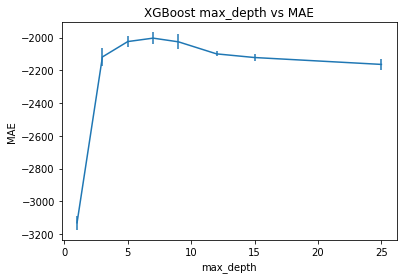

In [41]:
plot_params(model=grid_xgb, parameter_values=parameter_values, plot_title="XGBoost max_depth vs MAE", x_label="max_depth", y_label="MAE", verbose=False)

#### Tune number of learning_rate

In [42]:
parameter_values=[0.001, 0.01, 0.1, 0.2, 0.25, 0.3, 0.4, 0.6, 0.8, 0.9, 1, 2]
grid_xgb = check_param_estimate_with_model(estimator=XGBRegressor, parameter='learning_rate', parameter_values=parameter_values)

searching for the best parameters...
found best parameters...
Best score: -1947.1641863293523
Best params: {'learning_rate': 0.2}
Estimate of the data on a new sample data: 
The Train mae: 1407.2512193293433
The Test mae: 1983.888861656189


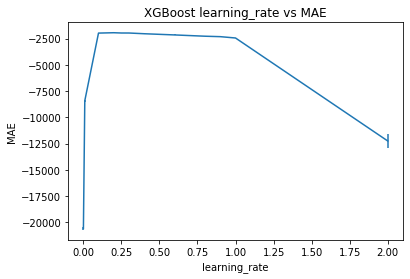

In [43]:
plot_params(model=grid_xgb, parameter_values=parameter_values, plot_title="XGBoost learning_rate vs MAE", x_label="learning_rate", y_label="MAE", verbose=False)

#### Tune number of subsample

In [44]:
parameter_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
grid_xgb = check_param_estimate_with_model(estimator=XGBRegressor, parameter='subsample', parameter_values=parameter_values)

searching for the best parameters...
found best parameters...
Best score: -1974.408368193166
Best params: {'subsample': 1.0}
Estimate of the data on a new sample data: 
The Train mae: 1301.3295352359294
The Test mae: 1992.4261409759522


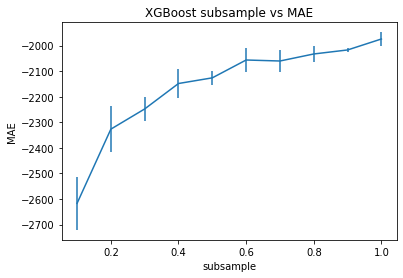

In [45]:
plot_params(model=grid_xgb, parameter_values=parameter_values, plot_title="XGBoost subsample vs MAE", x_label="subsample", y_label="MAE", verbose=False)

#### Tune number of colsample_bytree

In [46]:
parameter_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
grid_xgb = check_param_estimate_with_model(estimator=XGBRegressor, parameter='colsample_bytree', parameter_values=parameter_values)

searching for the best parameters...
found best parameters...
Best score: -1958.8220248758003
Best params: {'colsample_bytree': 0.5}
Estimate of the data on a new sample data: 
The Train mae: 1427.6665895509057
The Test mae: 1933.7288755562902


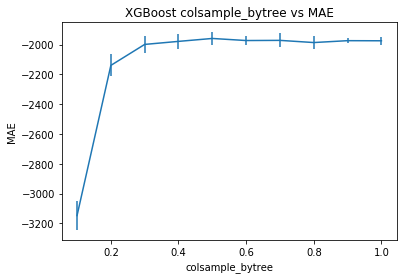

In [47]:
plot_params(model=grid_xgb, parameter_values=parameter_values, plot_title="XGBoost colsample_bytree vs MAE", x_label="colsample_bytree", y_label="MAE", verbose=False)

#### Tune number of reg_alpha

In [48]:
parameter_values=[0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0]
grid_xgb = check_param_estimate_with_model(estimator=XGBRegressor, parameter='reg_alpha', parameter_values=parameter_values)

searching for the best parameters...
found best parameters...
Best score: -1966.661934348273
Best params: {'reg_alpha': 1.0}
Estimate of the data on a new sample data: 
The Train mae: 1269.9383286520087
The Test mae: 1990.061407737732


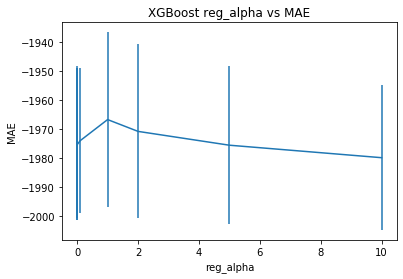

In [49]:
plot_params(model=grid_xgb, parameter_values=parameter_values, plot_title="XGBoost reg_alpha vs MAE", x_label="reg_alpha", y_label="MAE", verbose=False)

#### Tune number of reg_lambda

In [50]:
parameter_values=[0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0]
grid_xgb = check_param_estimate_with_model(estimator=XGBRegressor, parameter='reg_lambda', parameter_values=parameter_values)

searching for the best parameters...
found best parameters...
Best score: -1974.408368193166
Best params: {'reg_lambda': 1.0}
Estimate of the data on a new sample data: 
The Train mae: 1301.3295352359294
The Test mae: 1992.4261409759522


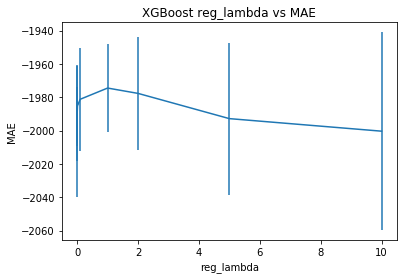

In [51]:
plot_params(model=grid_xgb, parameter_values=parameter_values, plot_title="XGBoost reg_lambda vs MAE", x_label="reg_lambda", y_label="MAE", verbose=False)

#### XGBoost -> Test all BEST combinations for sanity check

In [52]:
# Test all possible combinations
from models.estimators import XGBoostRegressor
xgb = XGBoostRegressor(df, colsample_bytree=0.5, subsample=1.0, learning_rate=0.2, max_depth=7, n_estimators=100)
xgb.train()
xgb.validate()
xgb.evaluate_model(metric="mae")

The Train mae: 1365.8734383864162
The Test mae: 1904.9824111557007


### Tuning with Bayesian Search

In [53]:
refined_params = {"colsample_bytree": Real(0.4, 1), "subsample": Real(0.4, 1), "learning_rate": Real(0.01, 1), "max_dept": Integer(3,15), "n_estimators": Integer(100,300)}

In [54]:
# search best params
bayes_xgb = BayesianSearchTuner(data= df, estimator=XGBRegressor, params = refined_params, cv=5, n_iter=100, metric="mae", verbosity = 0)
best_score, best_params = bayes_xgb.search_best()
print(f"Best score: {best_score}")
print(f"Best params: {best_params}")

Best score: -1884.5857995821348
Best params: OrderedDict([('colsample_bytree', 0.6245078326379802), ('learning_rate', 0.07702990702840093), ('max_dept', 15), ('n_estimators', 300), ('subsample', 0.8416508000885121)])


In [55]:
bayes_xgb.validate()
bayes_xgb.evaluate_model("mae")

The Train mae: 1411.8353786325404
The Test mae: 1941.668847427368


# Conclusion
- 
- 
- 
- 